In [45]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [46]:
MIN_LOOKBACK = max([
    21,  # EMA
    52,  # Ichimoku
    14,  # RSI
    14,  # Stochastic
    26,  # MACD
    20,  # Donchian
    20   # CMF
])

In [47]:
df = pd.read_csv("../data/coinbaseUSD_1-min_data.csv", header=0)

df['Date'] = pd.to_datetime(df['Date'])

df = df[-100000:]
# Set 'Date' as the index
df.set_index('Date', inplace=True)
df = df.drop(['Symbol', 'Unix Timestamp'], axis=1)
df.rename(columns={
    "Open":"open",
    "High":"high",
    "Low":"low",
    "Close":"close",
    "Volume":"volume"
}, inplace=True)



In [48]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)

In [49]:
# Technical indicators
df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)
df['RSI'] = ta.rsi(df.close, length=16)
df['RSI_8MIN'] = ta.rsi(df.close, length=8)
# my_bbands = ta.bbands(df.close, length=14, std=2.0)
macd = ta.macd(df.close)

# test_data = df[-55:]
# df = df[50:-55]

C:\Users\Pc\AppData\Local\Temp\ipykernel_17796\351530010.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["VWAP"] = ta.vwap(df.high, df.low, df.close, df.volume)


In [50]:
df = pd.concat([df, macd], axis=1)

                   open      high       low     close    volume      VWAP  \
open           1.000000  0.999975  0.999971  0.999956 -0.067139  0.994400   
high           0.999975  1.000000  0.999955  0.999977 -0.064231  0.994402   
low            0.999971  0.999955  1.000000  0.999976 -0.070841  0.994318   
close          0.999956  0.999977  0.999976  1.000000 -0.067528  0.994364   
volume        -0.067139 -0.064231 -0.070841 -0.067528  1.000000 -0.062438   
VWAP           0.994400  0.994402  0.994318  0.994364 -0.062438  1.000000   
RSI            0.012618  0.014095  0.014586  0.015591 -0.021809 -0.018604   
RSI_8MIN       0.008702  0.010649  0.011022  0.012532 -0.017664 -0.011367   
MACD_12_26_9   0.020421  0.020385  0.021462  0.021035 -0.069956 -0.024385   
MACDh_12_26_9 -0.001023 -0.000223  0.000160  0.000720 -0.021907 -0.003635   
MACDs_12_26_9  0.021947  0.021651  0.022672  0.022039 -0.067298 -0.024837   

                    RSI  RSI_8MIN  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26

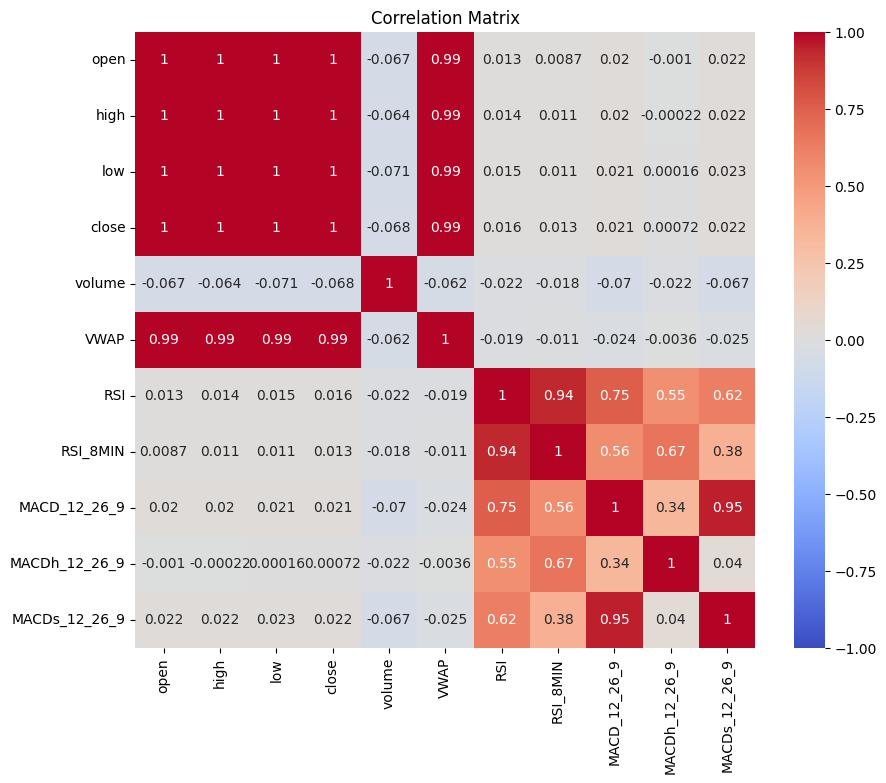

In [51]:
correlation_matrix = df[df.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [52]:
# Calculate Ichimoku indicators
ichimoku_visible, ichimoku_forward = df.ta.ichimoku(high=df['high'], low=df['low'], close=df['close'], tenkan=7, kijun=22, senkou=44)

# Add relevant Ichimoku columns from the 'visible' DataFrame to your main DataFrame
df['tenkan_sen'] = ichimoku_visible['ISA_7']
df['kijun_sen'] = ichimoku_visible['ISB_22']
df['span_a'] = ichimoku_visible['ITS_7']
df['span_b'] = ichimoku_visible['IKS_22']
df['chikou_span'] = ichimoku_visible['ICS_22']

In [ ]:
# last_timestamp = df_temp.index[-1]
# forward_timestamps = pd.date_range(start=pd.to_datetime(last_timestamp, unit='s'), 
#                                  periods=len(ichimoku_forward),
#                                  freq='1min')

# # Set proper index for forward values
# ichimoku_forward.index = forward_timestamps

In [53]:
def feature_engineering(df):
    # Видалення високо корельованих змінних
    
    # Створення нових ознак
    df['hl_range'] = df['high'] - df['low']
    df['oc_range'] = df['open'] - df['close']

    df['RSI_diff'] = df['RSI_8MIN'] - df['RSI']
    
    # Bollinger Bands
    # df['bb_width'] = (df['BBU_14_2.0'] - df['BBL_14_2.0']) / df['BBM_14_2.0']
    # df['bb_position'] = (df['close'] - df['BBL_14_2.0']) / (df['BBU_14_2.0'] - df['BBL_14_2.0'])
    
    # Логарифмічні різниці
    # df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    # df['log_volume_change'] = np.log(df['volume'] / df['volume'].shift(1))
        
    df['close_vwap_ratio'] = df['close'] / df['VWAP'] - 1
    
    # # Зміна VWAP
    # df['vwap_change'] = df['VWAP'].pct_change()
                   
    # Обчислення SMA та EMA
    df['SMA_10'] = df['close'].rolling(window=7).mean()
    df['EMA_5'] = df['close'].ewm(span=4, adjust=False).mean()
    
    # Відносне положення ціни закриття між SMA та EMA
    df['close_between_ma'] = (df['close'] - df['SMA_10']) / (df['EMA_5'] - df['SMA_10'])
    
    # Різниця між EMA та SMA

            
    # Нахил SMA та EMA
    # df['sma_slope'] = (df['SMA_10'] - df['SMA_10'].shift(1)) / df['SMA_10'].shift(1)
    # df['ema_slope'] = (df['EMA_5'] - df['EMA_5'].shift(1)) / df['EMA_5'].shift(1)

    # Ichimoku differences
    df['ichimoku_tenkan_kijun_diff'] = df['tenkan_sen'] - df['kijun_sen']
    df['ichimoku_close_kijun_diff'] = df['close'] - df['kijun_sen']
    df['ichimoku_span_a_b_diff'] = df['span_a'] - df['span_b']

     
    df = df.drop(['EMA_5', 'SMA_10', 'high', 'open', 'low', 'close', 'tenkan_sen', 'kijun_sen', 'span_a', 'span_b', 'chikou_span', 'RSI', 'MACD_12_26_9', 'MACDs_12_26_9'], axis=1)
    



    return df

In [54]:
df_engineered = feature_engineering(df)

                              volume      VWAP  RSI_8MIN  MACDh_12_26_9  \
volume                      1.000000 -0.062438 -0.017664      -0.021907   
VWAP                       -0.062438  1.000000 -0.011367      -0.003635   
RSI_8MIN                   -0.017664 -0.011367  1.000000       0.671140   
MACDh_12_26_9              -0.021907 -0.003635  0.671140       1.000000   
hl_range                    0.696730 -0.104307 -0.040072      -0.039847   
oc_range                    0.041386  0.004484 -0.407655      -0.185574   
RSI_diff                   -0.006029  0.003219  0.823282       0.672215   
close_vwap_ratio           -0.044975 -0.063436  0.221709       0.040948   
close_between_ma           -0.000143  0.000264 -0.003782      -0.000373   
ichimoku_tenkan_kijun_diff -0.016951 -0.010270 -0.026388      -0.296396   
ichimoku_close_kijun_diff  -0.067976 -0.019573  0.521018       0.175838   
ichimoku_span_a_b_diff     -0.037780 -0.007108  0.511662       0.468710   

                        

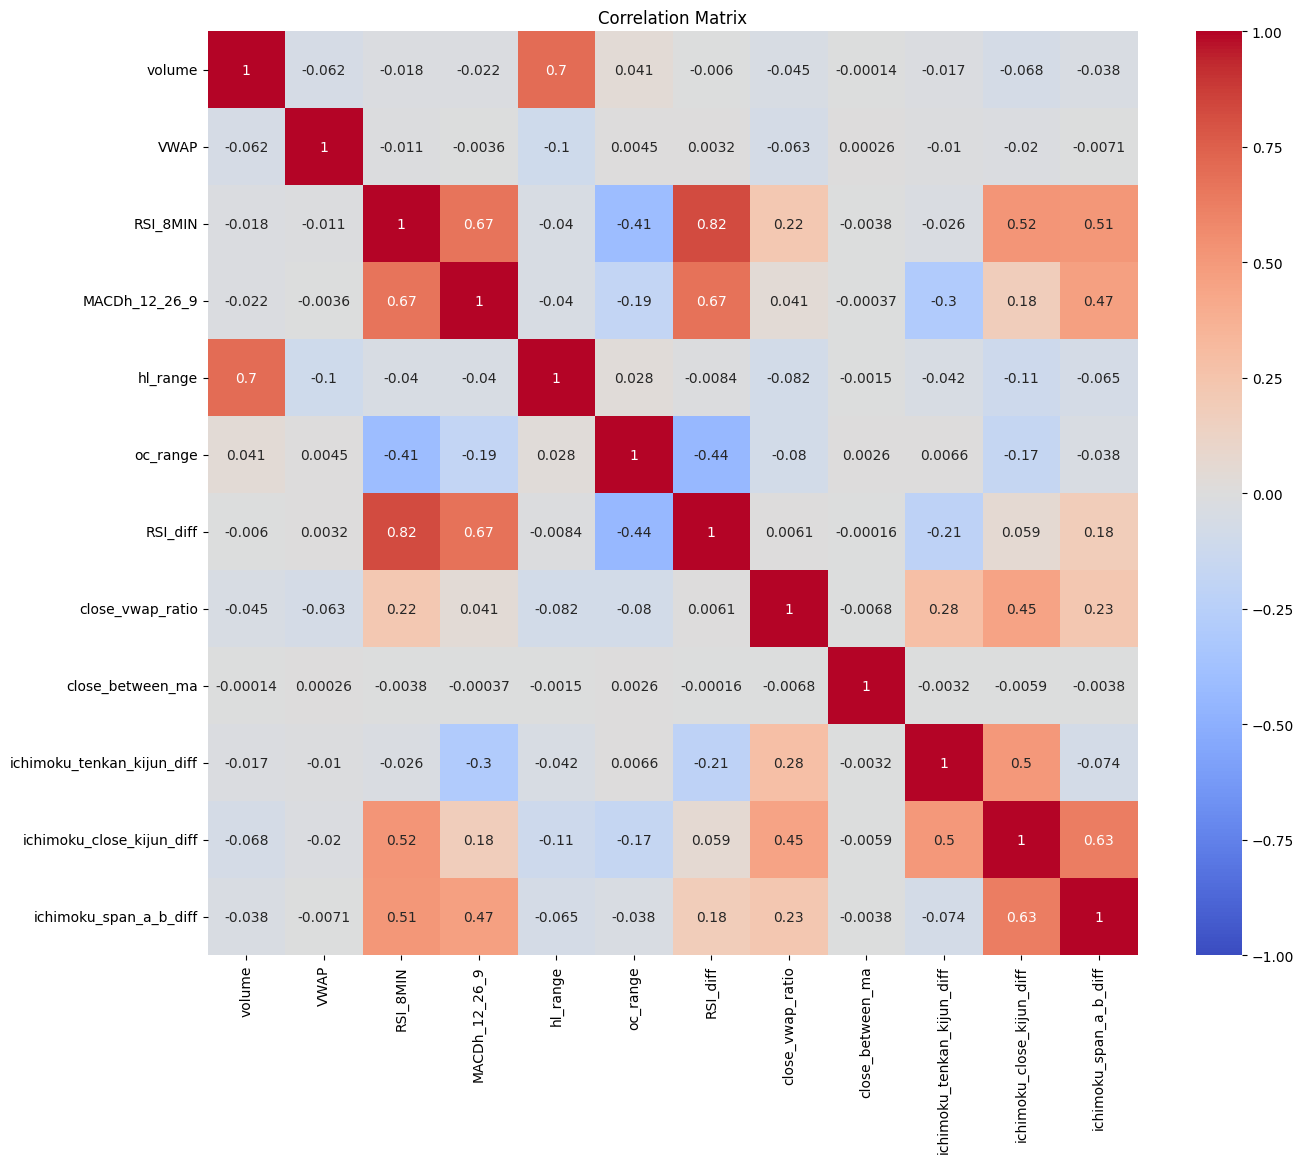

In [55]:
correlation_matrix = df_engineered[df_engineered.columns].corr()

# Create a heatmap of the correlation matrix
print(correlation_matrix)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

In [56]:

df_numeric = df_engineered.select_dtypes(include=[np.number])

# Define a scaler for features (all columns)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = feature_scaler.fit_transform(df_numeric)

In [58]:
scaled_data = scaled_data[100:]

In [59]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Припустимо, що у вас є датасет з 7 ознак, включаючи "close"
seq_length = 50
pred_length = 5

# Створюємо функцію для підготовки послідовностей
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])  # 50 рядків для навчання
        y.append(data[i+seq_length:i+seq_length+pred_length, 5])  # Прогнозуємо "close" (індекс 3)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length, pred_length)

# Кастомна функція втрат (MSE між двома векторами з 5 елементів)
def custom_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return mse

# Створюємо модель LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(pred_length)  # Передбачаємо 5 наступних значень "close"
])

# Використовуємо кастомну функцію втрат
model.compile(optimizer='adam', loss=custom_loss)

# Навчання моделі
history = model.fit(X, y, epochs=10, batch_size=32)

model.save_weights("../models/06_11_2024_lstm_model_weights.h5")

# # Прогнозуємо на останньому вікні і можемо перевірити на реальних даних
# last_sequence = X[-1]  # Беремо останні 50 кроків
# predicted_close = model.predict(last_sequence[np.newaxis, :, :])
# predicted_close = scaler.inverse_transform(predicted_close)  # Масштабуємо назад

# # Виводимо результати
# print("Прогнозовані 5 значень 'close':", predicted_close)
# print("Реальні 5 значень 'close':", df[-5:, 3])

Epoch 1/10
3121/3121 [==============================] - 44s 13ms/step - loss: 8.8818e-04
Epoch 2/10
3121/3121 [==============================] - 38s 12ms/step - loss: 4.8952e-04
Epoch 3/10
3121/3121 [==============================] - 39s 13ms/step - loss: 4.8110e-04
Epoch 4/10
3121/3121 [==============================] - 39s 13ms/step - loss: 4.7521e-04
Epoch 5/10
3121/3121 [==============================] - 40s 13ms/step - loss: 4.7187e-04
Epoch 6/10
3121/3121 [==============================] - 39s 12ms/step - loss: 4.6947e-04
Epoch 7/10
3121/3121 [==============================] - 40s 13ms/step - loss: 4.6850e-04
Epoch 8/10
3121/3121 [==============================] - 41s 13ms/step - loss: 4.6733e-04
Epoch 9/10
3121/3121 [==============================] - 40s 13ms/step - loss: 4.6780e-04
Epoch 10/10
3121/3121 [==============================] - 39s 12ms/step - loss: 4.6703e-04
